In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import pmdarima as pmd

In [14]:
df = pd.read_csv("housing_state.csv")
df.head()

,state,period_begin,total_homes_sold,total_value,AVG_median_sales_price
0,AK,2017-01-02,81.0,21202000.0,261753.086420
1,AK,2017-01-09,95.0,28384895.0,298788.368421
2,AK,2017-01-16,86.0,22529900.0,261975.581395
3,AK,2017-01-23,105.0,26613000.0,253457.142857
4,AK,2017-01-30,116.0,32739500.0,282237.068966


In [15]:
def process_the_data(df,var):
    scaler = MinMaxScaler()
    train_v = df[var].values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_v_normalized = scaler.fit_transform(train_v.reshape(-1, 1))
    train_v_normalized = torch.FloatTensor(train_v_normalized).view(-1)
    return scaler, train_v_normalized

In [16]:
def create_inout_sequences(input_data, tw):
    seq = []
    l = len(input_data)
    for i in range(l-tw):
        t_seq = input_data[i:i+tw]
        t_label = input_data[i+tw:i+tw+1]
        seq.append((t_seq ,t_label))
    return seq

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [18]:
def create_each_state_final(state,split_date = "2020-03-01" ):
    agg = df[df["state"]==state]
    split_date = split_date
    test = agg[agg.period_begin >=split_date]
    train = agg[agg.period_begin < split_date]
    #val = agg[(agg.period_begin >=vali_date)&(agg.period_begin<split_date)]
    return train, test

In [19]:
def final_model_prediction_on_test(train_,test):
    scaler_,input_data = process_the_data(train_,var = "total_value")
    train_window = 52
    train_input_seq = create_inout_sequences(input_data, train_window)
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 150

    for i in range(epochs):
        for seq, labels in train_input_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    fut_pred = 33

    test_inputs = input_data[-train_window:].tolist()
    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())
    #prediction = 
    prediction = scaler_.inverse_transform(np.array(test_inputs[train_window:] ).reshape(1, -1))
    #RMSE = np.sqrt(sum(np.square(vald["total_value"] - prediction[:,0]))/len(vald))
    #rms = np.sqrt(mean_squared_error(vald.total_value,prediction))
    #x = np.arange(8055,8085)
    #plt.plot(test.index,prediction)
    #plt.plot(test.total_value)
    #plt.show()
    return prediction

In [20]:
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              d=1,
                            start_p=0, 
                              start_q=0,
                              test="adf",         
                              seasonal=True,
                              stepwise=False,m=52,trace=True)
    return autoarima_model

In [21]:
df_arima = pd.read_csv("arima_prediction.csv")

In [22]:
answer = pd.read_csv("lstm_prediction.csv")
answer.rmse = np.sqrt(answer.rmse **2 /30)
answer.head()

,Unnamed: 0,state,rmse
0,0,AK,1.139046e+07
1,1,AL,3.513479e+07
2,2,AR,1.558703e+07
3,3,AZ,1.392329e+08
4,4,CA,9.491733e+08


In [23]:
final = answer.merge(df_arima,on=["state"])
final = final.iloc[:,1:]
#final
final.rename(columns={"rmse_x":"lstm_rmse","rmse_y":"sarima_rmse"},inplace=True)
final["which_model"] = np.where(final['lstm_rmse']>final["sarima_rmse"], 'sarima', 'lstm')
final.drop([final.columns[2]],axis=1,inplace=True)

final.to_csv("Model we use in each state.csv")

In [24]:
final.head()

,state,lstm_rmse,sarima_rmse,which_model
0,AK,1.139046e+07,1.521789e+07,lstm
1,AL,3.513479e+07,2.323108e+07,sarima
2,AR,1.558703e+07,1.684515e+07,lstm
3,AZ,1.392329e+08,7.326779e+07,sarima
4,CA,9.491733e+08,7.296775e+08,sarima


epoch:   1 loss: 0.14932215
epoch:  26 loss: 0.23919660
epoch:  51 loss: 0.11100817
epoch:  76 loss: 0.12667575
epoch: 101 loss: 0.13077106
epoch: 126 loss: 0.00576546
epoch: 149 loss: 0.0035107674


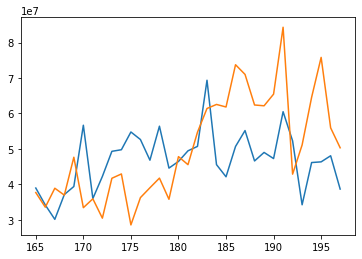

 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=6255.285, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=6207.109, Time=1.35 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=6199.513, Time=5.55 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=6193.761, Time=0.43 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=6195.761, Time=1.13 sec


KeyboardInterrupt: 

In [25]:
prediction_test = []
state = []
for w in range(47):
    state_split = final.state[w]
    state_model = final.which_model[w]
    
    train,test = create_each_state_final(state_split)
    if state_model =="lstm":
        prediction = final_model_prediction_on_test(train,test)[0].tolist()
        prediction_test.append(prediction)
    else:
        arima_model = arimamodel(train.total_value)
        prediction = arima_model.predict(len(test)).tolist()
        prediction_test.append(prediction)
        
    state.append(state_split)
    plt.plot(test.index,prediction)
    plt.plot(test.total_value)
    plt.show()

final_prediction = pd.DataFrame(prediction_test)    
final_prediction["state"] = state

final_prediction.head()